In [1]:
import os
import numpy as np
from time import time
from scipy.io import wavfile as wav

import matplotlib.pyplot as plt
import IPython.display as ipd

# Strumenti di classificazione
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.multiclass import unique_labels


In [2]:
# Segnaposto per feature extractor
def identity(input):
    return input

In [3]:
# Data loader
def load_data(feature_extractor=identity, normalize=False):

    labels = []
    features = []

    for f in sorted(os.listdir('/home/federico/Desktop/Università/II_ANNO/Digital_Signal_and_Image_Management/es2/recordings')):
        if f.endswith('.wav'):
            # Carica file ed estraine le features
            _, signal = wav.read('/home/federico/Desktop/Università/II_ANNO/Digital_Signal_and_Image_Management/es2/recordings/' + f)
            cur_features = feature_extractor(signal)
            features.append(cur_features)

            # Categorie
            label = f.split('_')[0]
            labels.append(label)

    # X: features, y: labels
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.1, random_state=1)

    if normalize:
        eps = 0.001
        X_train = np.array(X_train)
        X_train_mean = X_train.mean(axis=0)
        X_train_std = X_train.std(axis=0)
        X_train = (X_train - X_train_mean + eps)/(X_train_std + eps)
        X_train = [row for row in X_train]

        X_test = [row for row in (np.array(X_test) - X_train_mean + eps)/(X_train_std + eps)]

    return X_train, X_test, y_train, y_test

## Definizioni delle funzioni per estrarre le feature

In [4]:
def sdev(input):
    return np.std(input, keepdims = True)

In [5]:
def energy(input):
    return np.sum((input*1.0) ** 2, keepdims = True)

In [6]:
def aavg(input):
    return np.mean(np.abs(input), keepdims=True)

In [7]:
def duration(input):
    return input.shape

In [8]:
def zero_crossing(input):
    if np.sign(input[0]) == np.sign(input[-1]): # Se il seganle inizia e finisce con lo stesso segno
        res = (np.sum(np.abs(np.sign(input) - np.sign(np.roll(input, -1))), keepdims=True)/2)
    
    else: # Se il segnale inizia e finisce con segno opposto
        res = (np.sum(np.abs(np.sign(input) - np.sign(np.roll(input, -1))), keepdims=True)/2) - 1
    return res

In [9]:
def combo(input):
    return np.concatenate((aavg(input),duration(input) ,sdev(input), energy(input), zero_crossing(input)))

## Carico dati e split train e test

In [10]:
X_train, X_test , y_train, y_test = load_data(feature_extractor = combo, normalize = True)

## SVM

In [12]:
# Definizione dello spazio di ricerca per Grid Search degli iperparametri per una SVM
param_grid = {"C" : [100, 500, 1000, 1500, 2000],
              "gamma" : [0.0001, 0.005, 0.01, 0.015, 0.02, 0.1, 0.5, 1]}

In [18]:
clf = GridSearchCV(SVC(kernel = "rbf", class_weight = "balanced"), param_grid, cv = 2)

In [19]:
clf = clf.fit(X_train, y_train)

In [15]:
print("I parametri migliori risultano C : " + str(clf.best_estimator_.C) + " e gamma:" + str(clf.best_estimator_.gamma))

I parametri migliori risultano C : 100 e gamma:0.5


In [22]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.59      0.67        17
           1       0.47      0.80      0.59        10
           2       0.64      0.60      0.62        15
           3       0.85      0.58      0.69        19
           4       0.44      0.64      0.52        11
           5       0.50      0.71      0.59        14
           6       0.93      0.93      0.93        14
           7       0.78      0.37      0.50        19
           8       0.53      0.53      0.53        17
           9       0.59      0.71      0.65        14

    accuracy                           0.63       150
   macro avg       0.65      0.65      0.63       150
weighted avg       0.67      0.63      0.63       150



Matrice di confusione:
[[10  0  1  0  0  0  0  0  0  6]
 [ 0  8  0  0  2  0  0  0  0  0]
 [ 0  1  9  1  0  2  1  0  1  0]
 [ 0  3  2 11  0  3  0  0  0  0]
 [ 0  2  1  0  7  1  0  0  0  0]
 [ 0  0  0  0  3 10  0  1  0  0]
 [ 0  0  0  0  0  0 13  0  1  0]
 [ 0  1  0  0  2  2  0  7  6  1]
 [ 0  2  1  1  1  2  0  1  9  0]
 [ 3  0  0  0  1  0  0  0  0 10]]


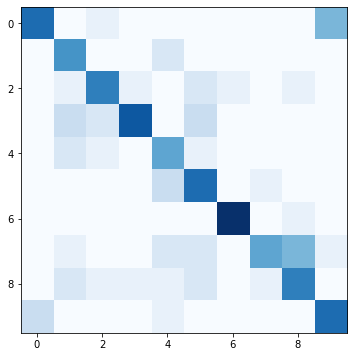

In [23]:
print("Matrice di confusione:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

plt.figure(figsize=(6,6))
plt.imshow(cm, cmap=plt.cm.Blues)

### Utilizzando come feature anche la "zero_crossing" l'accuracy passa dal circa 46% ottenuto a lezione al 63%. 
### Una classificazione migliore si sarebbe potuta ottenere calcolando altre feature (come mfcc) oppure cambiando il modello utilizzato.